# Import Libraries

In [5]:
! pip install pandas numpy torch transformers scikit-learn nltk seaborn matplotlib wordcloud beautifulsoup4


In [6]:
import pandas as pd
import numpy as np
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import ParameterGrid
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Loading and Pre-process

In [7]:
# Load the dataset
df = pd.read_csv('/content/Yelp Restaurant Reviews.csv')
df.head()


,Yelp URL,Rating,Date,Review Text
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...


In [8]:
# Clean the text (remove HTML tags, punctuation, etc.)
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Tokenize
    text = ' '.join([word for word in text if word not in stopwords.words('english')])  # Remove stopwords
    return text

df['cleaned_review'] = df['Review Text'].apply(clean_text)

# Handle missing values
df.dropna(subset=['cleaned_review'], inplace=True)

# Label the reviews with sentiment categories (positive, negative, neutral)
def label_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Rating'].apply(label_sentiment)

# Convert sentiment to numerical labels
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_mapping)

<ipython-input-8-6f604d969832>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


# Analysis

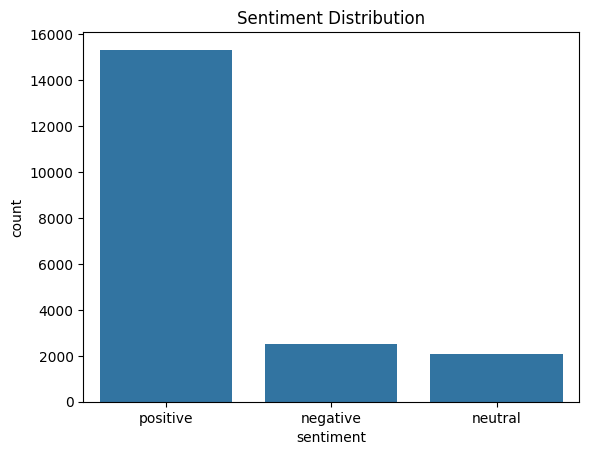

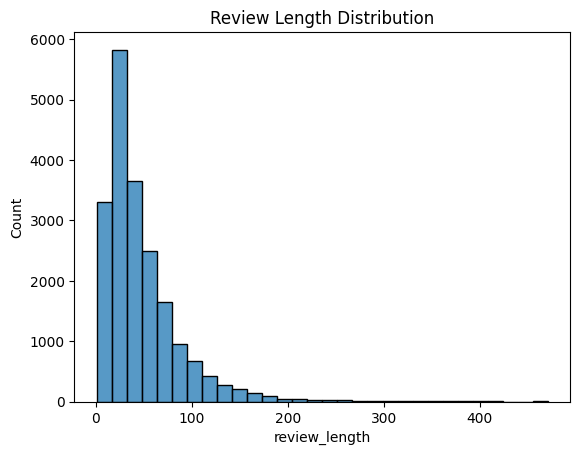

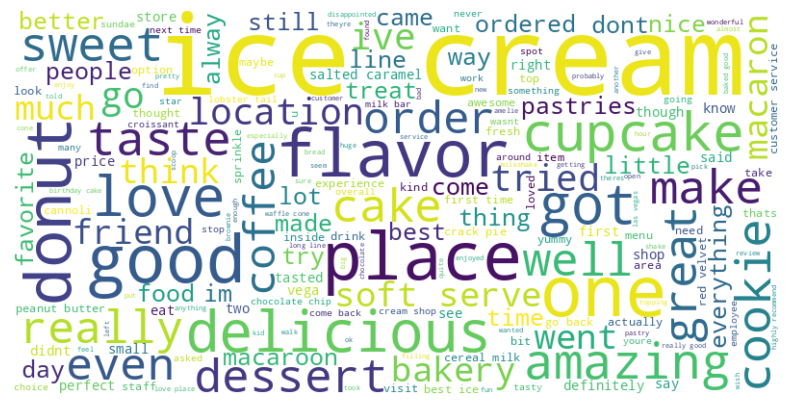

In [9]:
# Explore the distribution of sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Visualize the length of reviews
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=30)
plt.title('Review Length Distribution')
plt.show()

# Identify the most frequent words
all_words = ' '.join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Wordcloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [10]:
class YelpDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        review = self.dataframe.iloc[idx]['cleaned_review']
        label = self.dataframe.iloc[idx]['label']

        tokens = self.tokenizer(
            review,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }
        return item


In [11]:
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
df_sorted = df.sort_values(by='review_length', ascending=False).head(5000)

# Training and Hyperparameter tuning

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.models import Model

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X = df_sorted['Review Text'].values
y = df_sorted['Rating'].values
y = np.where(y > 3, 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=200)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=200)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(32)


input_ids = Input(shape=(200,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(200,), dtype=tf.int32, name='attention_mask')

class DistilBERTClassifier(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DistilBERTClassifier, self).__init__(**kwargs)
        self.distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract the [CLS] token
        return cls_output

cls_output = DistilBERTClassifier()([input_ids, attention_mask])

x = Dense(64, activation='relu')(cls_output)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 274ms/step - accuracy: 0.6301 - loss: 0.6969 - val_accuracy: 0.7220 - val_loss: 0.5952
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - accuracy: 0.6992 - loss: 0.6174 - val_accuracy: 0.7220 - val_loss: 0.5988
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.6992 - loss: 0.6134 - val_accuracy: 0.7220 - val_loss: 0.5953
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - accuracy: 0.6992 - loss: 0.6116 - val_accuracy: 0.7220 - val_loss: 0.5928
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - accuracy: 0.6992 - loss: 0.6117 - val_accuracy: 0.7220 - val_loss: 0.5931
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.6992 - loss: 0.6116 - val_accuracy: 0.7220 - val_loss: 0.5927
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.6992 - loss: 0.6114 - val_accuracy: 0.7220 - val_loss: 0.5933
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.6992 - loss: 0

# Save model

In [13]:
# Save the model weights and training history
model.save('distilbert_sentiment_model.keras')

history_df = pd.DataFrame({
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'val_acc': history.history['val_accuracy']
})
history_df.to_csv('distilbert_trainhistory.csv', index=False)

# Evaluation

In [14]:
from tensorflow.keras.models import load_model

loaded_model = load_model('distilbert_sentiment_model.keras', custom_objects={'DistilBERTClassifier': DistilBERTClassifier})

val_preds = []
val_labels = []

for batch in test_dataset:
    inputs, labels = batch

    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    labels = labels.numpy()

    logits = loaded_model.predict([input_ids, attention_mask])

    preds = (logits > 0.5).astype(int).flatten()

    val_preds.extend(preds)
    val_labels.extend(labels)

accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
recall = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print(classification_report(val_labels, val_preds, target_names=['negative', 'positive'], zero_division=0))


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━

In [15]:
import numpy as np

new_review = ["This restaurant was absolutely gross. The food was bad and the service was awful."]
new_review_encodings = tokenizer(new_review, truncation=True, padding=True, max_length=200, return_tensors='tf')

input_ids = new_review_encodings['input_ids']
attention_mask = new_review_encodings['attention_mask']

logits = loaded_model.predict([input_ids, attention_mask])

prediction = np.argmax(logits, axis=1)[0]

if prediction == 1:
    print("Positive sentiment")
else:
    print("Negative sentiment")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Negative sentiment
